In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('DataSets/ccf_online_stage1_train.csv')
df_off = pd.read_csv('DataSets/ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### Test Data (Offline)

In [5]:
df_test = pd.read_csv('DataSets/ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


### Converting Coupon to String Type

In [6]:
print('Data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes)+'\nTest: '+str(df_test['Coupon_id'].dtypes))
df_off['Coupon_id'] = [int(i) if i==i else i for i in df_off['Coupon_id']]
df_off['Coupon_id'] = df_off['Coupon_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isnull(x) else x)
df_test['Coupon_id'] = df_test['Coupon_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isnull(x) else x)
print('After conversion, data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes)+'\nTest: '+str(df_test['Coupon_id'].dtypes))

Data type of coupon in different datasets
Online: object
Offline: float64
Test: int64
After conversion, data type of coupon in different datasets
Online: object
Offline: object
Test: object


In [7]:
print('Data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes)+'\nTest: '+str(df_test['Coupon_id'].dtypes))

Data type of coupon in different datasets
Online: object
Offline: object
Test: object


#### Converting Date to DateTime format

In [8]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')


### Removing Duplicates from Online and Offline Training Data

In [9]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [10]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [11]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [12]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [13]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon[df_on_coupon['Coupon_id']!='fixed'].loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon['Discount_rate'].values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [14]:
df_on_coupon = df_on_coupon.append(df_on_unique[df_on_unique['Coupon_id']=='fixed'], sort=False)
df_on_coupon.shape, df_on_unique[df_on_unique['Coupon_id'].isna()==False].shape

((759100, 12), (759100, 8))

In [15]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,11951,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900
3,35,3381,11951,"[200, 20, 0.9]",0,2016-01-30,NaT,1,200:20,200,20,0.900
4,35,3381,1807,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900


### Training Data (Online + Offline)

In [16]:
df_train = df_on_unique.append(df_off_unique, sort=False)
df_train = df_train.sort_values(by = ['User_id'] )
df_train = df_train.reset_index()
del df_train['index']
print("Training Data(Offline+Online) \nShape:"+str(df_train.shape))
df_train.head()

Training Data(Offline+Online) 
Shape:(7539534, 9)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,35,3381,NaN,11951,200:20,2016-01-30,NaT,1,0.0


## User Anlaysis

## User distribution: Online, Offline and Test Data

In [17]:
users_on = set(df_on_unique['User_id'])
users_off = set(df_off_unique['User_id'])
users_test = set(df_test['User_id'])
len(users_on),len(users_off),len(users_test)

(762858, 539438, 76309)

In [18]:
all_three = (users_on.intersection(users_off)).intersection(users_test)
len(all_three) 
off_test_only = users_test.intersection(users_off) - all_three
off_on_only = users_on.intersection(users_off) - all_three
on_test_only = users_on.intersection(users_test) - all_three
len(off_test_only ),len(off_on_only),len(on_test_only)

(33153, 224294, 1)

In [19]:
only_test = users_test - (off_test_only.union(on_test_only)).union(all_three)
only_offline = users_off - (off_test_only.union(off_on_only)).union(all_three)
only_online = users_on - (off_on_only.union(on_test_only)).union(all_three)
len(only_test ),len(only_offline),len(only_online)

(1, 238837, 495409)

In [20]:
all_users = (users_on.union(users_off)).union(users_test)
len(all_users)

1034849

<img src ="imgs/UserDistribution.png" width="60%">

### Distributing users into three categores: 
1. users getting coupon
2. users making purchases without coupon
3. users making purchases with coupon

In [21]:
#Online
df_on_get_coupon = df_on_unique[df_on_unique['Action']==2]
df_on_no_coupon = df_on_unique[df_on_unique['Coupon_id'].isna()]
df_on_redeem_coupon = df_on_unique[(df_on_unique['Date'].isna()==False) & (df_on_unique['Coupon_id'].isna()==False)]
print('ONLINE: Shape of Get Coupon'+ str(df_on_get_coupon.shape))
print('ONLINE: Shape of No Coupon'+ str(df_on_no_coupon.shape))
print('ONLINE: Shape of Redeem Coupon'+ str(df_on_redeem_coupon.shape))

#Offline
df_off_get_coupon = df_off_unique[(df_off_unique['Date'].isna()) & (df_off_unique['Coupon_id'].isna()==False)]
df_off_no_coupon = df_off_unique[df_off_unique['Coupon_id'].isna()]
df_off_redeem_coupon = df_off_unique[(df_off_unique['Date'].isna()==False) & (df_off_unique['Coupon_id'].isna()==False)]
print('\nOFFLINE: Shape of Get Coupon'+ str(df_off_get_coupon.shape))
print('OFFLINE: Shape of No Coupon'+ str(df_off_no_coupon.shape))
print('OFFLINE: Shape of Redeem Coupon'+ str(df_off_redeem_coupon.shape))


#Complete Traininig Data
df_train_get_coupon = df_train[(df_train['Date'].isna()) & (df_train['Coupon_id'].isna()==False)]
df_train_no_coupon = df_train[df_train['Coupon_id'].isna()]
df_train_redeem_coupon = df_train[(df_train['Date'].isna()==False) & (df_train['Coupon_id'].isna()==False)]
print('\nONLINE+OFFLINE: Shape of Get Coupon'+ str(df_train_get_coupon.shape))
print('ONLINE+OFFLINE: Shape of No Coupon'+ str(df_train_no_coupon.shape))
print('ONLINE+OFFLINE: Shape of Redeem Coupon'+ str(df_train_redeem_coupon.shape))
df_train_coupon = df_on_coupon.append(df_off_coupon, sort=False)

ONLINE: Shape of Get Coupon(560986, 8)
ONLINE: Shape of No Coupon(5063443, 8)
ONLINE: Shape of Redeem Coupon(198114, 8)

OFFLINE: Shape of Get Coupon(942325, 8)
OFFLINE: Shape of No Coupon(701602, 8)
OFFLINE: Shape of Redeem Coupon(73064, 8)

ONLINE+OFFLINE: Shape of Get Coupon(1503311, 9)
ONLINE+OFFLINE: Shape of No Coupon(5765045, 9)
ONLINE+OFFLINE: Shape of Redeem Coupon(271178, 9)


### User : Online, Offline or Common(Online+Offline) Tag
        0: Common User
        1: Only Offline
        2: Only Online

In [22]:
users_on = set(df_on["User_id"].unique())             #number of users in online data
users_off = set(df_off["User_id"].unique())           #number of users in offline data
users_test = set(df_test["User_id"].unique())         #number of users in test data
common_users = set(users_off.intersection(users_on))  #number of users having both online and offline presence
online_users = list(users_on - common_users)
offline_users = list(users_off - common_users)
common_users = list(common_users)
print('Count of only Online Users:  '+ str(len(online_users)))
print('Count of only Offline Users: '+ str(len(offline_users)))
print('Count of Common Users:       '+ str(len(common_users)))

Count of only Online Users:  495410
Count of only Offline Users: 271990
Count of Common Users:       267448


In [23]:
common_tags = [0 for _ in range(len(common_users))]
offline_tags = [1 for _ in range(len(offline_users))]
online_tags = [2 for _ in range(len(online_users))]

#Common Users DataFrame
tag_0 = pd.DataFrame(
    {'Users': common_users,
     'Tag': common_tags
    })

#Offline Users DataFrame
tag_1 = pd.DataFrame(
    {'Users': offline_users,
     'Tag': offline_tags
    })

#Online Users DataFrame
tag_2 = pd.DataFrame(
    {'Users': online_users,
     'Tag': online_tags
    })

user_tag = tag_0.append(tag_1, sort=False)
user_tag = user_tag.append(tag_2, sort=False)
user_tag.sample(5)

,Users,Tag
378893,11280700,2
26922,6867010,1
334592,12246798,2
17771,33232,1
175536,4008200,1


### User Redemption Score 

In [24]:
#Users in training Dataset
user_redemption_train = pd.DataFrame(df_train_coupon.groupby(['User_id'])['Coupon_id','Date'].count()).reset_index()
user_redemption_train.columns = ['User_id','User_Released', 'User_Redeemed']
user_redemption_train['User_Ratio'] = round(user_redemption_train['User_Redeemed']/user_redemption_train['User_Released'],2)
# user_redemption_train[user_redemption_train['User_Ratio']!=0].head()
user_redemption_train.sample(4)

,User_id,User_Released,User_Redeemed,User_Ratio
192040,2706001,2,0,0.0
165383,2330033,2,0,0.0
349113,4909585,1,0,0.0
40983,578580,1,0,0.0


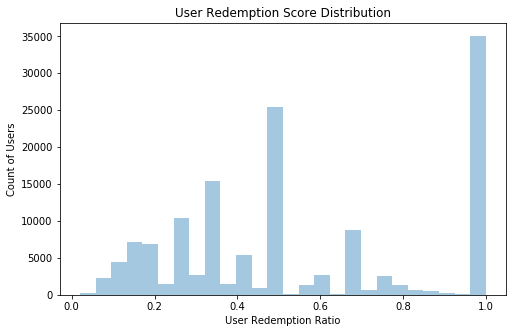

In [25]:
plt.figure(figsize=(8,5))
sns.distplot(user_redemption_train[user_redemption_train['User_Ratio']!=0]['User_Ratio'],kde=False,bins=26)
# sns.distplot(user_redemption_train['User_Ratio'],kde=False,bins=26)

plt.xlabel('User Redemption Ratio')
plt.ylabel('Count of Users')
plt.title('User Redemption Score Distribution')
plt.show()

### Users and their Merchant Preferences

In [26]:
visits= pd.DataFrame(df_train.groupby(['User_id','Merchant_id']).size()).reset_index()
visits.columns = ['User_id','Merchant_id','Visits']
visits.head()

,User_id,Merchant_id,Visits
0,4,1433,1
1,4,1469,1
2,4,25104,1
3,4,45612,1
4,35,3381,4


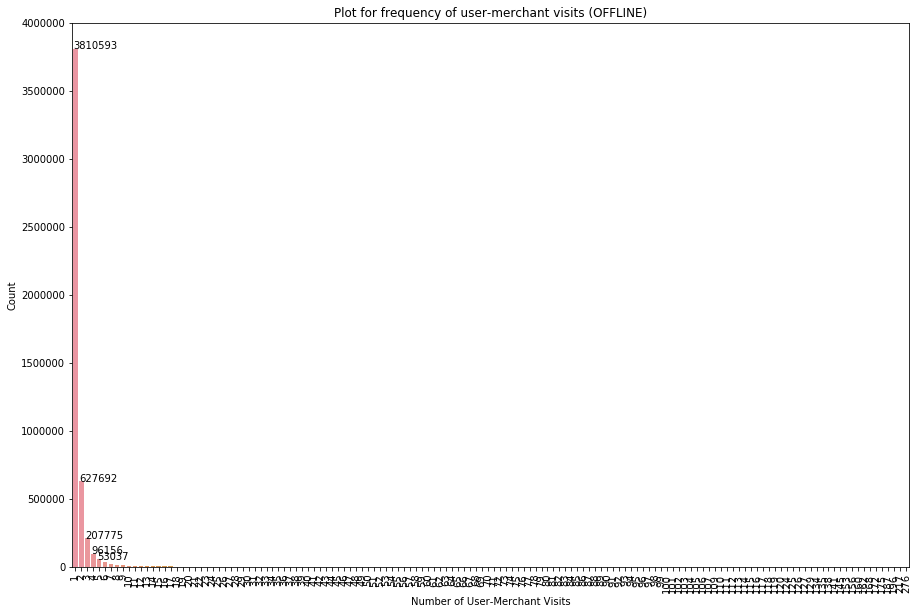

In [27]:
plt.figure(figsize=(15,10))
ax = sns.countplot(visits['Visits'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
i = 4
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        i-=1
        if i <0:
            break
plt.xlabel('Number of User-Merchant Visits')
plt.ylabel('Count')
plt.title('Plot for frequency of user-merchant visits (OFFLINE)')
plt.show()

#### For offline:
Around 69% of times the frequency of user-merchant pair is 1.<br>
#### For online:
Around 79.4% of times the frequency of user-merchant pair is 1.<br>
So, users don't prefer any certain set of merchants.

### Users as Purchasers and Non-Purchasers
Purchasers (Number of buys >= 5)<br>
Non Purchasers (Number of buys < 5)

In [28]:
user_purchasers = pd.DataFrame(df_train.groupby(['User_id'])['Date'].count())
user_purchasers.columns = ['User_Buys']
user_purchasers['User_Buys'].describe()

count    1.034848e+06
mean     5.832956e+00
std      1.057880e+01
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      2.532000e+03
Name: User_Buys, dtype: float64

In [29]:
user_purchasers['Purchaser'] = [1 if x>=5 else 0 for x in user_purchasers['User_Buys']] 
user_purchasers.sample(5)

,User_Buys,Purchaser
User_id,,
10706331,3,0
11198165,14,1
13090399,11,1
6199228,3,0
10207365,14,1


### For any user-merchant pair, the distance should remain constant (Offline)

In [30]:
user_merchant_distance = pd.DataFrame(df_off_unique.groupby(['User_id','Merchant_id'])['Distance'].nunique()).reset_index()
user_merchant_distance['Distance'].unique()

array([1])

Unique distance values for a user-merchant pair are 0 (for nan distance value) and 1.<br>
This shows for any user-merchant pair, the distance value remains constant.

### Users: Recent (Active during last month) or Not Recent 

In [31]:
users_purchase = df_train[df_train['Date'].isna()==False]
recent_users = pd.DataFrame(users_purchase.groupby(['User_id'])['Date'].agg(['max'])).reset_index()
recent_users.columns = ['User_id', 'LastActivityDate']
recent_users['LastDate'] = pd.to_datetime('20160701',format='%Y%m%d')
recent_users.head()

,User_id,LastActivityDate,LastDate
0,4,2016-03-08,2016-07-01
1,36,2016-01-20,2016-07-01
2,64,2016-06-06,2016-07-01
3,144,2016-02-14,2016-07-01
4,165,2016-06-17,2016-07-01


In [32]:
recent_users['RecentDuration'] = recent_users['LastDate'] - recent_users['LastActivityDate']
recent_users['RecentDuration'] = recent_users['RecentDuration'].dt.days.astype('str')
recent_users['RecentDuration'] = pd.to_numeric(recent_users['RecentDuration'],errors="coerce")
recent_users['RecentDuration'].describe()

count    845738.000000
mean         46.110416
std          44.474031
min           1.000000
25%          11.000000
50%          31.000000
75%          69.000000
max         182.000000
Name: RecentDuration, dtype: float64

In [33]:
recent_users['User_Recent'] = [1 if x<=31 else 0 for x in recent_users['RecentDuration']]
recent_users.head()

,User_id,LastActivityDate,LastDate,RecentDuration,User_Recent
0,4,2016-03-08,2016-07-01,115,0
1,36,2016-01-20,2016-07-01,163,0
2,64,2016-06-06,2016-07-01,25,1
3,144,2016-02-14,2016-07-01,138,0
4,165,2016-06-17,2016-07-01,14,1


In [34]:
bins = [0,10,20,30,40,50,60,70,80,90,182,200]
labels =[10,9,8,7,6,5,4,3,2,1,0]
recent_users['User_Recency_bucket'] = pd.cut(recent_users['RecentDuration'], bins,labels=labels)
recent_users.head()

,User_id,LastActivityDate,LastDate,RecentDuration,User_Recent,User_Recency_bucket
0,4,2016-03-08,2016-07-01,115,0,1
1,36,2016-01-20,2016-07-01,163,0,1
2,64,2016-06-06,2016-07-01,25,1,8
3,144,2016-02-14,2016-07-01,138,0,1
4,165,2016-06-17,2016-07-01,14,1,9


### Common Users: Online and Offline visits

In [35]:
df_train = df_train.merge(user_tag['Tag'],how='outer', left_on='User_id', right_on=user_tag['Users'])

In [36]:
common_users = df_train[df_train['Tag']==0]
common_users_activity = common_users.groupby(['User_id'])['Action','Distance'].count()
common_users_activity.columns = ['Online_Activity','Offline_Activity']
common_users_activity.sample(2)

,Online_Activity,Offline_Activity
User_id,,
5997444,9,3
6811599,7,14


### User tracking (Online click to Offline buy)

In [37]:
common_users['Action'].fillna(3, inplace=True)
common_users.loc[:,('Action')] = [4 if (x==3) & (y==y) else x for (x,y) in zip(common_users['Action'],common_users['Date'])]
common_users.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,Tag
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN,0
1,4,1433,3.0,8735,30:5,2016-02-14,NaT,1,10.0,0
2,4,1469,3.0,2902,0.95,2016-06-07,NaT,1,10.0,0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,0
8,36,1041,3.0,13490,30:5,2016-01-25,NaT,1,4.0,0


In [38]:
common_users.loc[:,('DateTrack')] = common_users.loc[:,('Date')]
common_users.DateTrack.fillna(common_users.Date_received, inplace=True)
common_users.loc[:,('Action')] = common_users.loc[:,('Action')].astype(int)
common_users.loc[:,('Action')] = common_users.loc[:,('Action')].astype(str)
common_users.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,Tag,DateTrack
0,4,25104,2,100145044,100:10,2016-03-31,NaT,1,NaN,0,2016-03-31
1,4,1433,3,8735,30:5,2016-02-14,NaT,1,10.0,0,2016-02-14
2,4,1469,3,2902,0.95,2016-06-07,NaT,1,10.0,0,2016-06-07
3,4,45612,1,NaN,NaN,NaT,2016-03-08,1,NaN,0,2016-03-08
8,36,1041,3,13490,30:5,2016-01-25,NaT,1,4.0,0,2016-01-25


In [39]:
common_users = common_users.sort_values(by=['User_id','DateTrack'])
common_users.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,Tag,DateTrack
1,4,1433,3,8735,30:5,2016-02-14,NaT,1,10.0,0,2016-02-14
3,4,45612,1,NaN,NaN,NaT,2016-03-08,1,NaN,0,2016-03-08
0,4,25104,2,100145044,100:10,2016-03-31,NaT,1,NaN,0,2016-03-31
2,4,1469,3,2902,0.95,2016-06-07,NaT,1,10.0,0,2016-06-07
10,36,46701,0,NaN,NaN,NaT,2016-01-20,1,NaN,0,2016-01-20


In [40]:
common_user_activity = common_users.groupby(['User_id'])['Action'].apply(list).reset_index(name='ActivityList')
common_user_activity.head()

,User_id,ActivityList
0,4,"[3, 1, 2, 3]"
1,36,"[0, 3, 3]"
2,64,"[3, 0, 0, 1]"
3,144,"[0, 3]"
4,165,"[4, 3, 4, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, ..."


In [41]:
common_user_activity.loc[:,('ActivityList')] = common_user_activity.loc[:,('ActivityList')] .apply(lambda x: ''.join(x))
common_user_activity.loc[:,('OnlineToOffline')] = [1 if re.search('\d*0\d*4\d*',a) else 0 for a in common_user_activity['ActivityList']]
common_user_activity.head(20)

,User_id,ActivityList,OnlineToOffline
0,4,3123,0
1,36,033,0
2,64,3001,0
3,144,03,0
4,165,434434444144444344,0
5,173,00030,0
6,184,3411,0
7,209,0114,1
8,215,000000000001110001014100103,1
9,236,333222130,0


In [42]:
common_user_activity[common_user_activity['OnlineToOffline']==1].shape[0]/common_user_activity.shape[0]

0.1873971762735186

## User not redeeming coupons (Journey Tracking)

In [43]:
redemption_tracking = df_train[(df_train['Date'].isna()) | (df_train['Coupon_id'].isna())]
redemption_tracking.loc[:,('DateTrack')] = redemption_tracking.loc[:,('Date')]
redemption_tracking['DateTrack'].fillna(redemption_tracking['Date_received'],inplace=True)
redemption_tracking.loc[:,('Purchasing')] = [1 if x==x else 0 for x in redemption_tracking['Date']]
redemption_tracking.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,Tag,DateTrack,Purchasing
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN,0,2016-03-31,0
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0,0,2016-02-14,0
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0,0,2016-06-07,0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,0,2016-03-08,1
4,35,3381,NaN,11951,200:20,2016-01-30,NaT,1,0.0,1,2016-01-30,0


In [44]:
users_redemption_tracking = pd.DataFrame(redemption_tracking.groupby(['User_id','Merchant_id'])['Purchasing'].nunique()).reset_index()
notredeeming = users_redemption_tracking[users_redemption_tracking['Purchasing']==2].reset_index(drop=True)
notredeeming.columns = ['User_id','Merchant_id','Purchase_unique']
notredeeming.head(5)

,User_id,Merchant_id,Purchase_unique
0,165,2934,2
1,165,4195,2
2,215,129,2
3,236,53305,2
4,239,3465,2


In [45]:
tracking_noredeem = pd.merge(redemption_tracking,notredeeming)
tracking_noredeem = tracking_noredeem.drop(['Purchase_unique','Distance','Count','Discount_rate'],axis=1)
tracking_noredeem = tracking_noredeem.sort_values(by=['User_id','Merchant_id','DateTrack'])
tracking_noredeem.head(10)

,User_id,Merchant_id,Action,Coupon_id,Date_received,Date,Tag,DateTrack,Purchasing
13,165,2934,NaN,NaN,NaT,2016-01-11,0,2016-01-11,1
12,165,2934,NaN,NaN,NaT,2016-01-25,0,2016-01-25,1
11,165,2934,NaN,NaN,NaT,2016-03-21,0,2016-03-21,1
14,165,2934,NaN,5686,2016-03-22,NaT,0,2016-03-22,0
10,165,2934,NaN,NaN,NaT,2016-03-28,0,2016-03-28,1
9,165,2934,NaN,NaN,NaT,2016-04-14,0,2016-04-14,1
8,165,2934,NaN,NaN,NaT,2016-05-10,0,2016-05-10,1
15,165,2934,NaN,NaN,NaT,2016-06-02,0,2016-06-02,1
7,165,2934,NaN,NaN,NaT,2016-06-17,0,2016-06-17,1
5,165,4195,NaN,NaN,NaT,2016-04-06,0,2016-04-06,1


In [46]:
tracking_noredeem['Purchase_difference'] = tracking_noredeem.groupby(['User_id','Merchant_id'])['Purchasing'].apply(lambda x: x -  x.shift(1))


In [47]:
tracking_noredeem['Date_difference'] = tracking_noredeem.groupby(['User_id','Merchant_id'])['DateTrack'].apply(lambda x: x -  x.shift(1))


In [48]:
tracking_noredeem.head()

,User_id,Merchant_id,Action,Coupon_id,Date_received,Date,Tag,DateTrack,Purchasing,Purchase_difference,Date_difference
13,165,2934,NaN,NaN,NaT,2016-01-11,0,2016-01-11,1,NaN,NaT
12,165,2934,NaN,NaN,NaT,2016-01-25,0,2016-01-25,1,0.0,14 days
11,165,2934,NaN,NaN,NaT,2016-03-21,0,2016-03-21,1,0.0,56 days
14,165,2934,NaN,5686,2016-03-22,NaT,0,2016-03-22,0,-1.0,1 days
10,165,2934,NaN,NaN,NaT,2016-03-28,0,2016-03-28,1,1.0,6 days


In [49]:
tracking_noredeem['Date_difference'] = tracking_noredeem['Date_difference'].dt.days.astype('str')
tracking_noredeem['Date_difference'] = pd.to_numeric(tracking_noredeem['Date_difference'],errors="coerce")
tracking_noredeem.head(10)

,User_id,Merchant_id,Action,Coupon_id,Date_received,Date,Tag,DateTrack,Purchasing,Purchase_difference,Date_difference
13,165,2934,NaN,NaN,NaT,2016-01-11,0,2016-01-11,1,NaN,NaN
12,165,2934,NaN,NaN,NaT,2016-01-25,0,2016-01-25,1,0.0,14.0
11,165,2934,NaN,NaN,NaT,2016-03-21,0,2016-03-21,1,0.0,56.0
14,165,2934,NaN,5686,2016-03-22,NaT,0,2016-03-22,0,-1.0,1.0
10,165,2934,NaN,NaN,NaT,2016-03-28,0,2016-03-28,1,1.0,6.0
9,165,2934,NaN,NaN,NaT,2016-04-14,0,2016-04-14,1,0.0,17.0
8,165,2934,NaN,NaN,NaT,2016-05-10,0,2016-05-10,1,0.0,26.0
15,165,2934,NaN,NaN,NaT,2016-06-02,0,2016-06-02,1,0.0,23.0
7,165,2934,NaN,NaN,NaT,2016-06-17,0,2016-06-17,1,0.0,15.0
5,165,4195,NaN,NaN,NaT,2016-04-06,0,2016-04-06,1,NaN,NaN


## User and number of unique merchants

In [50]:
user_merchant_count = pd.DataFrame(df_train.groupby(['User_id'])['Merchant_id'].nunique().reset_index(name='UserMerchantCount'))
user_merchant_count.head()

,User_id,UserMerchantCount
0,4,4
1,35,1
2,36,3
3,64,3
4,110,3


## User Recency list

In [51]:
user_dates = df_train[df_train['Date'].isna()==False]
user_dates['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
user_dates['DayNum'] = user_dates['Date'] - user_dates['First_day'] 
user_dates['DayNum'] = user_dates['DayNum'].dt.days.astype('str')
user_dates['DayNum'] = pd.to_numeric(user_dates['DayNum'],errors="coerce") + 1
user_dates

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance,Tag,First_day,DayNum
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN,0,2016-01-01,68
10,36,46701,0.0,NaN,NaN,NaT,2016-01-20,1,NaN,0,2016-01-01,20
12,64,11200,0.0,NaN,NaN,NaT,2016-05-26,1,NaN,0,2016-01-01,147
13,64,29214,0.0,NaN,NaN,NaT,2016-06-06,1,NaN,0,2016-01-01,158
14,64,29214,1.0,NaN,NaN,NaT,2016-06-06,1,NaN,0,2016-01-01,158
...,...,...,...,...,...,...,...,...,...,...,...,...
7539529,15499999,31001,0.0,NaN,NaN,NaT,2016-04-09,1,NaN,2,2016-01-01,100
7539530,15499999,31001,0.0,NaN,NaN,NaT,2016-04-08,1,NaN,2,2016-01-01,99
7539531,15499999,35600,0.0,NaN,NaN,NaT,2016-03-13,1,NaN,2,2016-01-01,73
7539532,15499999,45009,0.0,NaN,NaN,NaT,2016-03-08,1,NaN,2,2016-01-01,68


In [52]:
user_days = pd.DataFrame(user_dates.groupby(['User_id'])['DayNum'].apply(list).reset_index(name='DayList'))

In [53]:
user_days['DayList'] = user_days['DayList'].apply(lambda x : sorted(set(x)))
user_days

,User_id,DayList
0,4,[68]
1,36,[20]
2,64,"[147, 158]"
3,144,[45]
4,165,"[11, 25, 81, 88, 97, 103, 105, 110, 111, 116, ..."
...,...,...
845733,15499965,"[2, 6, 8, 9, 10, 17, 20, 25, 54, 57, 58, 63, 7..."
845734,15499966,"[104, 106, 143, 151]"
845735,15499998,"[7, 87, 170]"
845736,15499999,"[4, 6, 7, 9, 16, 22, 27, 58, 59, 65, 66, 68, 7..."


## USER LEVEL FEATURES

In [54]:
users_level_data = pd.DataFrame(df_train['User_id'].unique()).reset_index(drop=True)
users_level_data.columns = ['User_id']
users_level_data.shape

(1034848, 1)

In [55]:
#Adding Offline(1) or Online+Offline (Common User : 0) Tag of the user
users_level_data = users_level_data.merge(user_tag['Tag'],how='left', left_on='User_id', right_on=user_tag['Users'])

#Adding Number of coupons redeemed by each user and its redemption score
users_level_data = pd.merge(users_level_data, user_redemption_train, how='left', on='User_id')
# users_level_data = pd.merge(users_level_data, user_redemption_train['User_Ratio'], how='left', left_on='User_id', right_on=user_redemption_train['User_id'])

#Adding number of Buys of each User and Purchaser(Buys>=5) or NotPurchaser
users_level_data = pd.merge(users_level_data,user_purchasers['User_Buys'], how='left', left_on='User_id', right_on=user_purchasers.index)
users_level_data = pd.merge(users_level_data,user_purchasers['Purchaser'], how='left', left_on='User_id', right_on=user_purchasers.index)

#Recent users (active during last month) or not
# users_level_data = pd.merge(users_level_data,recent_users['User_Recent'], how='left', left_on='User_id', right_on=recent_users.index)
# users_level_data['User_Recent'].fillna(0, inplace=True)

#User and number of unique merchants
users_level_data = pd.merge(users_level_data,user_merchant_count,how='left',on='User_id')

#User purchases day list
users_level_data = pd.merge(users_level_data,user_days,how='left',on='User_id')

# users_level_data = pd.merge(users_level_data,recent_users['User_Recency_bucket'], how='left', left_on='User_id', right_on=recent_users.index)
# users_level_data['User_Recency_bucket'].fillna(0, inplace=True)

In [56]:
for row in users_level_data.loc[users_level_data.DayList.isnull(), 'DayList'].index:
    users_level_data.at[row, 'DayList'] = []
users_level_data.fillna(0, inplace=True)

In [57]:
users_level_data.isna().sum()

User_id              0
Tag                  0
User_Released        0
User_Redeemed        0
User_Ratio           0
User_Buys            0
Purchaser            0
UserMerchantCount    0
DayList              0
dtype: int64

In [58]:
users_level_data

,User_id,Tag,User_Released,User_Redeemed,User_Ratio,User_Buys,Purchaser,UserMerchantCount,DayList
0,4,0,3.0,0.0,0.00,1,0,4,[68]
1,35,1,4.0,0.0,0.00,0,0,1,[]
2,36,0,2.0,0.0,0.00,1,0,3,[20]
3,64,0,1.0,0.0,0.00,3,0,3,"[147, 158]"
4,110,1,3.0,0.0,0.00,0,0,3,[]
...,...,...,...,...,...,...,...,...,...
1034843,15499965,2,2.0,1.0,0.50,54,1,40,"[2, 6, 8, 9, 10, 17, 20, 25, 54, 57, 58, 63, 7..."
1034844,15499966,2,0.0,0.0,0.00,5,1,3,"[104, 106, 143, 151]"
1034845,15499998,2,0.0,0.0,0.00,3,0,3,"[7, 87, 170]"
1034846,15499999,2,7.0,1.0,0.14,61,1,45,"[4, 6, 7, 9, 16, 22, 27, 58, 59, 65, 66, 68, 7..."


In [59]:
users_level_data.to_csv('DataSets/DatasetsCreated/user_level.csv',index=False) 

In [60]:
len(users_on.union(users_off))

1034848